In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import salem
from cdo import *
from pathlib import Path
from os import path, remove
import sys
import geopandas as gpd
from cftime import Datetime360Day
cdo = Cdo()
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *
import _pickle as cpickle

In [120]:
seasIndex = pd.Index(['Annual', "JJAS", "ON", "DJF", "MAM"], name='seas')

In [9]:
shp = (gpd
       .read_file('/home/abhi/Documents/data/shapefiles/India_climatic_correct/India_climatic_correct.shp'))

shp = shp.loc[~shp.Region.str.startswith('Him'), :]

In [145]:
def subsetbygdf(ds, gdf, region_col, apply_fldmean=True):
    
    regionIndex = gdf[region_col]
    regionIndex.name = 'region'
    if apply_fldmean:
        return xr.concat([fldmean(ds.salem.roi(shape=gdf.loc[gdf.index == index], 
                                              all_touched=False))
                         for index in gdf.index],
                        dim=regionIndex)
    
    else: 
        pass

In [261]:
def subsetbygdf_new(ds, gdf, region_col, apply_fldmean=True):
    
    regionIndex = gdf[region_col]
    if apply_fldmean:
        objs = [fldmean(ds.salem.roi(shape=gdf.loc[gdf.index == index], 
                                              all_touched=True))
                         for index in gdf.index]
        
        regionIndex = pd.concat(
            [regionIndex, pd.Series(['Core Monsoon', 'India'])], ignore_index=True)
        regionIndex.name = 'region'
        
        objs.append(fldmean(sellonlatbox(ds, [73, 82, 18, 28])))
        objs.append(fldmean(ds))
        
        return xr.concat(objs,
                        dim=regionIndex)
    
    else: 
        pass

### Zone wise statistics

In [146]:
with open("../pickles/Analysis-3/combined_metric.pkl", "rb") as f:
    metric_ds = cpickle.load(f)

In [147]:
metric_df = subsetbygdf(metric_ds, shp, 'Region').to_dataframe().reset_index()

In [262]:
metric_df2 = subsetbygdf_new(metric_ds, shp, 'Region').to_dataframe().reset_index()

In [263]:
metric_df2.head()

,metric,model,region,seas,var_name,VAR
0,BIAS,PRECIS,Northern,Annual,precip,-0.389641
1,BIAS,PRECIS,Northern,Annual,tmax,-19.123909
2,BIAS,PRECIS,Northern,Annual,tmean,-20.120182
3,BIAS,PRECIS,Northern,Annual,tmin,-21.399990
4,BIAS,PRECIS,Northern,JJAS,precip,-1.083013


In [281]:
def sel_df(metric, seas, var, omit_region=None):
    df = metric_df2.loc[((metric_df2.metric == metric) & 
               (metric_df2.seas == seas) &
               (metric_df2.var_name == var)), :]
    
    
    return df.drop(df[np.isin(df.region, omit_region)].index)

In [210]:
seas = 'Annual'
var = 'precip'

In [219]:
ax.get_legend_handles_labels()

([<BarContainer object of 6 artists>, <BarContainer object of 6 artists>],
 ['PRECIS', 'HADGEM2-ES'])

In [ ]:
fig.sub

In [288]:

def BIAS_RMSE_plot(var, seas, savefig=False):
    fig, axn = plt.subplots(2, 1, figsize=(12, 8))
    if var == 'precip':
        units = 'mm $d^{-1}$'
    else:
        units = "$^\circ$C"
    
    for ax, metric in zip(axn, ['BIAS', 'RMSE']):
        df = sel_df(metric, seas, var, omit_region=['Northern', 'India'])

        sns.barplot(x='region', y='VAR', hue='model', data=df, ax=ax,
                   palette=['steelblue', 'crimson'])
        
        ax.set_ylabel(f"{metric} ({units})", fontweight='bold')
        handles, labels = ax.get_legend_handles_labels()
    #     ax.legend_.remove()

    # fig.legend(handles=handles, labels=labels, loc='center right',
    #           bbox_to_anchor=[0.9, 0.5])

    titles = {'precip': 'Precipitation',
             'tmean': 'Mean Temperature',
             'tmax': 'Max Temperature',
             'tmin': 'Min Temperature'}

    fig.suptitle(f"{titles[var]} ({seas} mean)", fontweight='bold', fontsize=15)
    fig.subplots_adjust(top=0.92)
    
    if savefig:
        outdir=f'../plots/compare/{var}/regionwise'
        os.system(f'mkdir -p {outdir}')
        fig.savefig(f'{outdir}/BIAS_RMSE_{seas}_PRECIS_HADGEM2-ES.png', dpi=400, 
                   bbox_inches='tight')
        plt.close(fig)
        

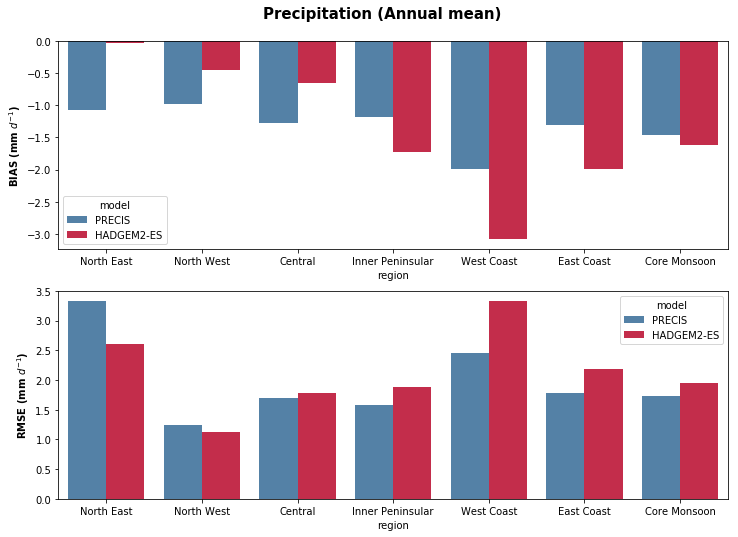

In [289]:
check_df = BIAS_RMSE_plot('precip', 'Annual', False)

In [280]:
check_df

,metric,model,region,seas,var_name,VAR
741,RMSE,PRECIS,North East,Annual,tmax,5.153548
761,RMSE,PRECIS,North West,Annual,tmax,2.297281
781,RMSE,PRECIS,Central,Annual,tmax,2.159356
801,RMSE,PRECIS,Inner Peninsular,Annual,tmax,1.435472
821,RMSE,PRECIS,West Coast,Annual,tmax,1.456707
841,RMSE,PRECIS,East Coast,Annual,tmax,2.124007
861,RMSE,PRECIS,Core Monsoon,Annual,tmax,1.206601
881,RMSE,PRECIS,India,Annual,tmax,3.806705
921,RMSE,HADGEM2-ES,North East,Annual,tmax,8.743814
941,RMSE,HADGEM2-ES,North West,Annual,tmax,4.842936


In [290]:
for var in ['precip']:
    for seas in ['Annual', 'JJAS', 'ON', 'DJF', 'MAM']:
        BIAS_RMSE_plot(var, seas, savefig=True)

In [216]:
ax.legend_.remove()

In [54]:
with open("../pickles/Analysis-3/combined_ymean.pkl", "rb") as f:
    combined_ymean = cpickle.load(f)

In [56]:
%%time
combined_region = subsetbygdf(combined_ymean, shp, "Region")

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 1.84 s, sys: 444 ms, total: 2.28 s
Wall time: 2.27 s


/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [58]:
DIFF = combined_region.sel(model=['PRECIS', 'HADGEM2-ES']).precip - combined_region.sel(model='IMD')

In [80]:
STD = combined_region.std(dim="year")

In [84]:
STD.sel(var_name='precip')

<xarray.Dataset>
Dimensions:   (model: 3, region: 7, seas: 5)
Coordinates:
  * model     (model) object 'IMD' 'PRECIS' 'HADGEM2-ES'
    var_name  <U6 'precip'
  * seas      (seas) object 'Annual' 'JJAS' 'ON' 'DJF' 'MAM'
  * region    (region) object 'Northern' 'North East' ... 'East Coast'
Data variables:
    precip    (region, seas, model) float32 0.7070233 0.27101824 ... 0.22083855

In [60]:
RMSE = (DIFF**2).mean(dim="year")**(1/2)

In [62]:
RMSE_df = RMSE.rename({'precip': 'VAR'}).to_dataframe().reset_index()

In [66]:
RMSE_df.head()

,model,region,seas,var_name,VAR
0,PRECIS,Northern,Annual,precip,0.883274
1,PRECIS,Northern,Annual,tmax,19.440651
2,PRECIS,Northern,Annual,tmean,20.494207
3,PRECIS,Northern,Annual,tmin,21.860113
4,PRECIS,Northern,JJAS,precip,1.526380


In [161]:
df = RMSE_df.loc[(
               (RMSE_df.seas == 'JJAS') &
               (RMSE_df.var_name == 'precip')), :]

In [177]:
df

,metric,model,region,seas,var_name,VAR
4,BIAS,PRECIS,Northern,JJAS,precip,-1.037665
24,BIAS,PRECIS,North East,JJAS,precip,-3.214499
44,BIAS,PRECIS,North West,JJAS,precip,-2.683694
64,BIAS,PRECIS,Central,JJAS,precip,-3.526839
84,BIAS,PRECIS,Inner Peninsular,JJAS,precip,-2.612891
104,BIAS,PRECIS,West Coast,JJAS,precip,-5.076844
124,BIAS,PRECIS,East Coast,JJAS,precip,-1.676706
144,BIAS,HADGEM2-ES,Northern,JJAS,precip,0.312124
164,BIAS,HADGEM2-ES,North East,JJAS,precip,-0.322936
184,BIAS,HADGEM2-ES,North West,JJAS,precip,-2.319284


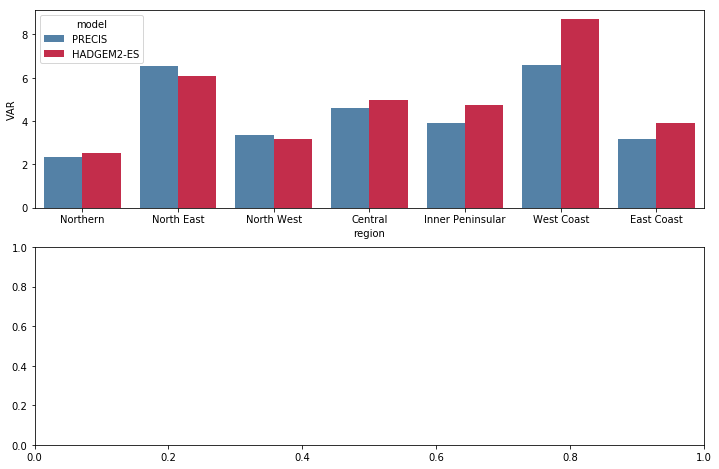

In [258]:
fig, axn = plt.subplots(2, 1, figsize=(12, 8))
sns.barplot(x='region', y='VAR', hue='model', data=df, ax=axn[0], palette=['steelblue',
                                                                         'crimson'])

In [251]:
ax= axn[0]

In [254]:
ax.get_legend_handles_labels()[0]

[<BarContainer object of 6 artists>, <BarContainer object of 6 artists>]

In [114]:
gcm_o = xr.open_dataset('/home/abhi/Documents/mygit/GCM_RCM/data/HADGEM2-ES_O/precip/monmean/1971-2000_rm_ll25_monmean.nc')
gcm_o_fldmean = subsetbygdf(gcm_o, shp, 'Region')

In [115]:
gcm = xr.open_dataset('/home/abhi/Documents/mygit/GCM_RCM/data/HADGEM2-ES/precip/monmean/1971-2000_rm_ll25_monmean.nc')
gcm_fldmean = subsetbygdf(gcm, shp, 'Region')

In [125]:
diff_int = (gcm_fldmean - gcm_o_fldmean/(gcm_o_fldmean))*100

In [126]:
meandiff_int = xr.concat([timmean(diff_int)]+[timmean(selseas(diff_int, seas)) 
                               for seas in seasIndex[1:]],
                         dim=seasIndex)

In [127]:
df = meandiff_int.pr.to_dataframe()

In [128]:
df

pr
seas   region                       
Annual Northern           188.758530
       North East         480.653748
       North West           4.550075
       Central            124.560501
       Inner Peninsular   -13.961176
       West Coast          -0.040242
       East Coast          34.280876
JJAS   Northern           239.121674
       North East        1057.631470
       North West          44.389236
       Central            381.338776
       Inner Peninsular    83.627525
       West Coast         136.203400
       East Coast         165.504379
ON     Northern            88.284157
       North East          33.137287
       North West         -47.771282
       Central            -39.533859
       Inner Peninsular   -40.534012
       West Coast         -25.645426
       East Coast          13.170392
DJF    Northern            75.395592
       North East          46.780849
       North West         -14.421765
       Central              9.693046
       Inner Peninsular   -63.259159
       West Coast         -77.970352
       East Coast         -42.687241
MAM    Northern           301.953430
       North East         443.567200
       North West           5.283924
       Central              6.453149
       Inner Peninsular   -77.066254
       West Coast         -86.698196
       East Coast         -49.641888

In [173]:
combined_region.precip.sel(model='IMD').values.shape

(7, 5, 4, 30)

In [ ]:
np.correlate()

In [171]:
%%time
res = np.apply_along_axis(np.corrcoef, y=axis=-1, arr=combined_region.precip.values)

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 39.6 ms


In [172]:
res

array([[[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1., nan],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1., nan],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]]],


       [[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1., nan],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1., nan],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],

        [[ 1.,  1.,  1.],
         [ 1.,  1.